# Live Video and Audio Analysis For Detecting Anomalies

#### Team Name : Tech_Triggers_777
#### Team ID : O1023
#### Name : Prateek Sarna
#### Email : prateeksarna24@gmail.com
#### Discord : prateek1234#1704

### Note : Every peice of code in this File has written During the Hackathon.

### This Project is Devided into 2 Parts
- Video Temporal Analysis
- Audio Analysis by Topic Modeling

### The dataset used is UCF-101.
"UCF101 - Action Recognition Data Set" which is a commonly used dataset for action recognition tasks. It contains videos of human actions collected from YouTube. The dataset is composed of 13,320 videos from 101 action categories.

## Project Explanation
### Vision
- To achieve a way to instantly remove or stop a live video by analyzing if there is any bad content.
### How to Achieve?
- Analysis of any live video could be done in both visual and audio formats.
- So the Project is Devided into 2 parts first is video analysis and 2nd is Audio Analysis.
### Limitation
- The limitation for this project is that there is no VULGAR dataset publicaly available.
- Also, since the data is very big to process and require a lot of computaional power, I will just be using a portion of data and upto 2 categories / classes.
### Solution
- So to solve this drawback I am using a genric dataset with day to day actions performed by humans. These are generally the things such as "Applying Makeup", "Writing on a board".
- For now the approach is to train the model with good data and see how the model performs, if the required dataset becomes available the model would be retrained according to it.
### Approach
- For Video
    - Using a pre-trained 3D CNN model for video data processing.Using R(2 + 1)D
    - Video = Sequence of Frames(Images)
    - Using the Sequence of frames to predict the category of action.
- For Audio
    - I will extract audio from the video itself.
    - Then I will be converting the audio file to text file.
    - Then I will use Topic Modeling to get different patterns.
    - And then analyze those patterns to find any anomaly.
### Main Libraries used
- OpenCV
- PyTorch
- SpeechRecogniton
- Librosa

### Importing Libraries

In [1]:
import cv2 as cv
import os
import librosa
from librosa.display import waveshow
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import warnings
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv3D, MaxPooling3D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from librosa.feature import melspectrogram
import visualkeras
import pydot_ng
import pydotplus
import graphviz
from PIL import Image
import random
import torch
import torchvision
import torch.nn as nn
import speech_recognition  as sr
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from moviepy.editor import VideoFileClip
warnings.filterwarnings('ignore')

#### Main Data Directory Path

In [2]:
main_data_dir_path = 'UCF-101'

## 1. Video Analysis

### Essential Functions 

In [3]:
## this function returns the array of frames of a video.
def get_video_frames(capture) :
    video = []
    while True :
        frame = capture.read()[1]
        if np.any(frame == None) :
            break
        else :
            video.append(frame)
    return video

In [4]:
## Traversing OS Folder to get metadata.
def get_metadata(data_dir) :
    metadata = []
    for class_folder in os.listdir(data_dir) :
        class_target = class_folder
        for video_file in os.listdir(os.path.join(data_dir,class_folder)) :
            metadata.append((os.path.join(os.path.join(data_dir,class_folder), video_file), class_target))
    return pd.DataFrame(metadata, columns = ['File Name', 'Class_Target'])

In [5]:
## Since the time is limited, I am using only a small portion of the dataset.
def get_limited_data(metadata) :
    needed_class = ['WritingOnBoard', 'WallPushups']
    limited_data = []
    
    for class_ in needed_class :
        df = metadata[metadata['Class_Target'] == class_]
        limited_data.append(df.values)
    
    new_data = []
    for each_class in limited_data:
        for each_file_and_class in each_class :
            new_data.append(each_file_and_class)
    
    return pd.DataFrame(new_data, columns = ['File Name', 'Class_Target'])

In [6]:
## Load all video Data
def get_all_videos_in_frame_format(video_dataframe) :
    video_files = video_dataframe['File Name']
    video_files_loaded = []
    
    for video_file in video_files :
        capture = cv.VideoCapture(video_file)
        ## use of above defined function.
        video = get_video_frames(capture)
        video_files_loaded.append(video)
    
    return video_files_loaded

In [7]:
def resize_frames(Video_Data) :
    desired_width = 100
    desired_height = 100
    
    itr_i = 0
    for videos in Video_Data :
        itr_j = 0
        for frames in videos :
            resized_frame = cv.resize(frames, (desired_width, desired_height), interpolation=cv.INTER_AREA)
            gray_frame = cv.cvtColor(resized_frame, cv.COLOR_BGR2GRAY)
            videos[itr_j] = gray_frame
            itr_j += 1
        Video_Data[itr_i] = videos
        itr_i += 1
    
    return Video_Data

In [8]:
def reshape_videos(Video_Data) :
    max_frames = 100
    frame_shape = Video_Data[0][0].shape # (240, 320, 1)
    
    itr = 0
    for videos in Video_Data :
        no_of_frames = len(videos)
        frames_needed = max_frames - no_of_frames
        if (frames_needed > 0) :
            for i in range(frames_needed) :
                padding_frame = np.full(frame_shape, 0)
                videos.append(padding_frame)
        elif (frames_needed < 0) :
            Video_Data[itr] = videos[:max_frames]
        else :
            pass
        itr += 1
    
    return Video_Data

### Main

In [9]:
## creating metadata
## for getting metadata, I am traversing the folder in OS. And appending each file path and its cateegory.
metadata = get_metadata(main_data_dir_path)
## Extracting only partial data as discuused above
limited_data = get_limited_data(metadata)
## Loading Video Data
Video_Data = get_all_videos_in_frame_format(limited_data)
## Resize the images for faster execution.
Video_Data = resize_frames(Video_Data)
## reshape images or change the number of channels.
Video_Data = reshape_videos(Video_Data)

### Pre-Trained Model

In [10]:
model = torchvision.models.video.r2plus1d_18(pretrained=True)

input_shape = (1, 100, 100, 100)  

stem_layer = nn.Conv3d(in_channels=3, out_channels=45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3))
model.stem[0] = stem_layer

num_classes = 2  # For binary classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Setting the model to evaluation mode.
model.eval()

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3))
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

### Predicting from the model

In [11]:
# Define the data loaders
# Example data tensors (replace these with your actual data)
X_train_tensor = torch.randn(211, 1, 100, 100, 100)  # Example training data tensor
y_train_tensor = torch.randint(0, 2, (211,))  # Example training labels tensor
X_test_tensor = torch.randn(71, 1, 100, 100, 100)  # Example test data tensor
y_test_tensor = torch.randint(0, 2, (71,))  # Example test labels tensor

batch_size = 4 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained R(2+1)D model
model = torchvision.models.video.r2plus1d_18(pretrained=True)

# Modify the input shape and stem layer
input_shape = (1, 100, 100, 100)  # 1 channel for grayscale, and 100 frames of size (100, 100)

stem_layer = nn.Conv3d(in_channels=1, out_channels=45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3))
model.stem[0] = stem_layer

# Modify the output layer for binary classification
num_classes = 2  # For binary classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
y_pred = []
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 50.70422535211268%


#### Note - Accuracy is low because I am using a very small portion of data and the pre-trained model is might not be well suited for the categories I used.

## 2. Audio Analysis

### Essential Functions

In [12]:
def text_from_audio(audio_file_path) :
    r = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = r.record(source)
        try:
            text = r.recognize_google(audio_data)
            print(f"Transcribed Text: {text}")
        except sr.UnknownValueError:
            print("Speech Recognition could not understand the audio")
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
    return text

In [13]:
def preprocess_text(text):
    return preprocess_string(text)

In [14]:
def audio_from_video(video_file_path) :
    audio_output_path = os.path.join("Converted Audio.wav") 
    video = VideoFileClip(video_file_path)
    audio = video.audio

    audio.write_audiofile(audio_output_path, codec='pcm_s16le')
    return audio_output_path

### Analyzing 1 file

In [15]:
sample_video_file = limited_data.values[0][0]
sample_video_file

'UCF-101\\WritingOnBoard\\v_WritingOnBoard_g01_c01.avi'

In [16]:
## Extracting audio file from video
audio_output_path = audio_from_video(sample_video_file)
## extracting text from audio file
text_data = text_from_audio(audio_output_path)
text_data = preprocess_text(text_data)
text_data

MoviePy - Writing audio in Converted Audio.wav


MoviePy - Done.


Transcribed Text: Yuvraj Singh score


['yuvraj', 'singh', 'score']

### Plotting Audio File and Waveplot

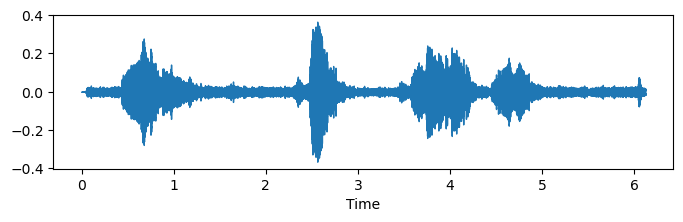

In [17]:
plt.figure(figsize=(8,2))
audio_data, sr = librosa.load(audio_output_path)
waveshow(np.array(audio_data), sr = sr)
Audio(data = audio_data, rate = sr)

### Function To Play a video

In [18]:
def play_video(sample_video_file) :
    capture = cv.VideoCapture(sample_video_file)
    # Check if the video file is opened successfully
    if not capture.isOpened():
        print("Error opening video file")
        exit()

    # Read the video frame by frame
    while capture.isOpened():
        ret, frame = capture.read()

        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        # Display the frame
        cv2.imshow('Frame', frame)

        # Press 'q' to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break